# Introduction to saliency mapping with CNNs

<a href="https://colab.research.google.com/drive/1ti9W_W2LjZxbc-0JU6GZSGOZH3Mt5kHn" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

Return to the [castle](https://github.com/Nkluge-correa/TeenyTinyCastle).

Convolutional Neural Networks are the cornerstone for numerous contemporary AI applications, particularly those centered around visual data processing. CNNs excel in extracting hierarchical patterns and features from visual data, making them essential in tasks that require vision, such as autonomous vehicles, medical imaging diagnostics, facial recognition systems, and much more. Hence, understanding the workings of models like CNNs becomes paramount, especially in high-risk domains, due to the critical consequences of malfunction or misuse.

To help us achieve this, we have Explainable AI (**XAI**) on our side. XAI (specifically in CV applications) has formed two major exploration threads when interpreting CNNs: **feature visualization** and **saliency mapping**. This notebook focuses on **saliency mapping** techniques.

![image](https://raw.githubusercontent.com/jacobgil/keras-cam/master/examples/dog.jpg)

[Source](https://github.com/jacobgil/keras-cam).

In this notebook, we will interpret a CNN trained on the [`CIFAR-10`](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, a collection of labeled images from the [80 million tiny images dataset](https://groups.csail.mit.edu/vision/TinyImages/) (currently taken down). CIFAR-10 is one of the most widely used datasets for machine learning research, containing 60,000 32x32 color images in 10 different classes. These classes are airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks (6,000 images of each class).

Training the CNN we will be exploring is outside the scope of this notebook. So, we are just going to upload a pre-trained model. You can find a tutorial on how to train a CNN in this [notebook](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Explainability/CV/CNN_model_maker.ipynb). Our pre-trained model is available on the Hub. 🤗

> **Note: For a comprehensive explanation of the limitations and difficulties related to saliency mapping techniques, we recommend "[Evaluating Saliency Map Explanations for Convolutional Neural Networks: A User Study](https://arxiv.org/abs/2002.00772)". For a complete guide on ML Explainability, we recommend "[Interpretable Machine Learning: A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)".**



In [1]:
!pip install huggingface_hub["tensorflow"] -q

# We are loading our Keras model from the Hub via the `huggingface_hub.from_pretrained_keras`
from huggingface_hub import from_pretrained_keras
import tensorflow as tf

model = from_pretrained_keras("AiresPucrs/Cifar-CNN")
model.trainable = False
model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/687 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

mobilevnet2_adversaries.png:   0%|          | 0.00/585k [00:00<?, ?B/s]

model.png:   0%|          | 0.00/75.6k [00:00<?, ?B/s]

volcano_CAM.jpg:   0%|          | 0.00/157k [00:00<?, ?B/s]

variables/variables.index:   0%|          | 0.00/3.08k [00:00<?, ?B/s]

Cifar_CNN.h5:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

adversarial_data_CIFAR_10.npy:   0%|          | 0.00/297M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/2.23M [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/426k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/48.4k [00:00<?, ?B/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

Now, let us quickly test our CNN against the test set of CIFAR-10.

170498071/170498071 [==============================] - 4s 0us/step


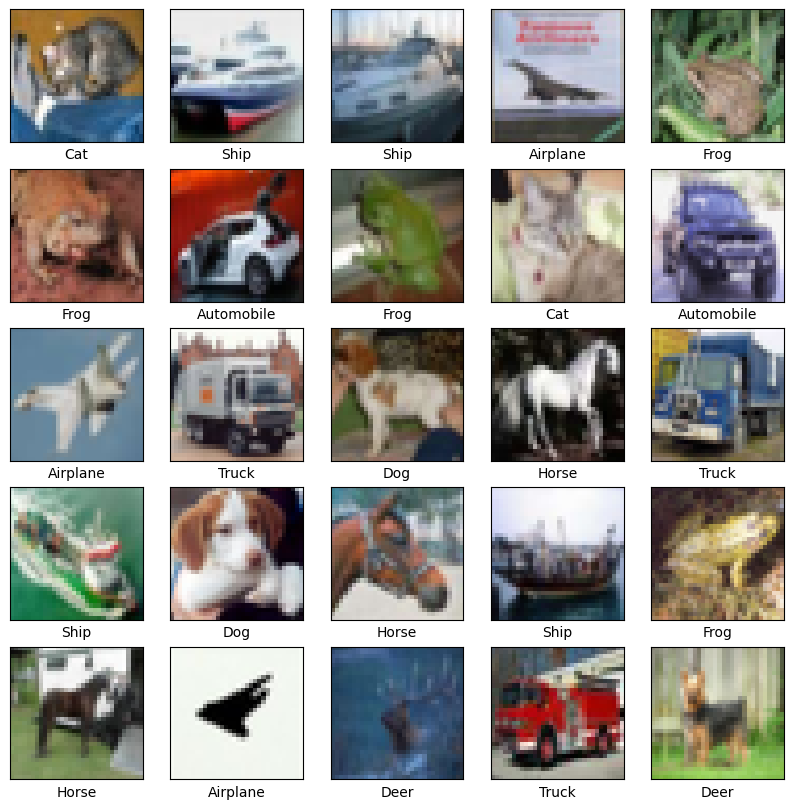

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset from the Keras API
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# These are the classes names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Preprocess the images in the test set
x_test = x_test.astype('float32')
x_test = x_test / 255.
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Make predictions and get classes for the first 25 images
# `np.expand_dims` is to add the batch dimension
# `np.argmax` is to get the class number from the softmax distribution
predictions = [np.argmax(model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)) for i in range (25)]

# Plot the predictions
plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[predictions[i]])

plt.show()

Great! Everything seems to be working fine. Now, let us do some Ssaliency mapping. Saliency maps, also referred to as **Class Activation Maps** (CAM), provide a straightforward way to pinpoint the key areas in an image that a CNN focuses on when recognizing a particular object or class within the image. Essentially, a saliency map highlights which parts of the image are most influential in the network's decision-making process for that specific class.

The underlying idea behind this technique can be simplified as follows:

> **The stronger the activation of specific channels in response to the input image and the greater their relevance to the target class, the more prominently these areas contribute to the network's classification decision.**

The technique we are using in this notebook is **Gradient-weighted Class Activation Mapping** (Grad-CAM), proposed in "[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)". Grad-CAM uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the concept. If you wish to better understand the ideas that led to Grad-CAM, we recommend this [video made by the paper's authors](https://www.youtube.com/watch?v=COjUB9Izk6E). For the rest of the tutorial, we will only worry about implementing it.

> **Note: You can find the original implementation of Grad-CAM in [this GitHub repository](https://github.com/ramprs/grad-cam/).**

To start, we need to get the final layer of our CNN before the input is flattened and passed through the classification MLP. In Keras, you can get the name of every layer of your model by calling the `layers` method.

In [3]:
for layer in model.layers:
    print(layer.name)

conv2d
batch_normalization
conv2d_1
batch_normalization_1
max_pooling2d
dropout
conv2d_2
batch_normalization_2
conv2d_3
batch_normalization_3
max_pooling2d_1
dropout_1
conv2d_4
batch_normalization_4
conv2d_5
batch_normalization_5
max_pooling2d_2
dropout_2
flatten
dense
batch_normalization_6
dropout_3
dense_1


We will use `batch_normalization_5` as the last convolutional layer from this CNN, given that all spatial features are flattened right after. Also, let us randomly choose an image we can use as the subject of our exploration.

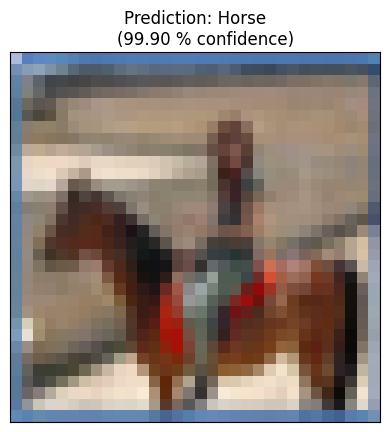

In [12]:
# Pick up a ramdom sample index
sample = np.random.randint(0, 9999) # 2657 is the index of our Horse image!

# create the image tensor by adding the batch dimension
img_tensor = np.expand_dims(x_test[sample], axis=0)

# Generate the prediciton
predictions = [num for num in list(model.predict(img_tensor, verbose=0)[0])]

# Plot the image and the prediciton
plt.figure()
plt.imshow(x_test[sample])
plt.title(
    f'''Prediction: {class_names[np.array(predictions).argmax()]}
    ({max(predictions) * 100:.2f} % confidence)''')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

Below, we create two functions: one to generate the array of values that represent our saliency map (`create_saliency_map`), and another to generate this map as a plotly heatmap (`create_saliency_map`).

In [13]:
import plotly.express as px

def MakeGradcamMap(image, model, last_conv_layer_name="batch_normalization_5", pred_index=None):
    """
    Returns a Grad-CAM (Gradient-weighted Class Activation Map) heatmap for a
    given input image, generated using a pre-trained model and a specific
    convolutional layer.

    Args:
        - image: A numpy array representing the input image.
        - model: A pre-trained Keras model to be used in the Grad-CAM algorithm.
        - last_conv_layer_name: A string representing the name of the convolutional
            layer used in the Grad-CAM algorithm.
        - pred_index: An integer representing the predicted index of the model's
            output, used in the Grad-CAM algorithm. Defaults to None.

    Returns:
        - A numpy array representing the Grad-CAM heatmap of the input image.
    """
    # Define a new Keras model with the same input as 'model' but with two outputs:
    # the output of the specified last convolutional layer ('last_conv_layer_name')
    # and the final output of the model.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Create a batch of images with a single image by adding an extra dimension at the beginning.
    img_array = np.expand_dims(image, axis=0)

    # Use TensorFlow's GradientTape to record operations for automatic differentiation.
    # Compute the output of 'grad_model' and select the prediction corresponding to 'pred_index' if provided,
    # otherwise select the prediction with the highest confidence.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = np.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute the gradients of the selected class channel with respect to the model's last convolutional layer output
    # using automatic differentiation.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Calculate the mean of gradients across the spatial dimensions (width, height)
    # and the channel dimension of the gradients computed in the previous step.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the heatmap by performing a dot product between the output of the last convolutional layer
    # and the pooled gradients. Remove any singleton dimensions to make the heatmap compatible with visualization.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap values by scaling them between 0 and 1.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Return the computed heatmap as a NumPy array.
    return heatmap.numpy()


def CreateSaliencyMap(heatmap):
    """
    Create a saliency map from a given heatmap.

    Args:
        heatmap (numpy.ndarray): The heatmap to create the saliency map from.

    Returns:
        None.
    """

    # Ensure all values in the heatmap are non-negative.
    saliency_map = np.maximum(heatmap, 0)

    # Normalize the saliency map values by scaling them between 0 and 1.
    saliency_map /= np.max(saliency_map)

    # Create a Plotly figure to display the saliency map.
    fig = px.imshow(saliency_map,
                    title=f'Saliency Map',
                    text_auto=True)

    fig.update_layout(
        {
        'template': 'plotly_dark',
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'title_x': 0.5,
        'coloraxis_showscale': False,
        }
      )

    # Show the Plotly figure.
    return fig.show()

# Set the activation function of the last layer in the model to None.
model.layers[-1].activation = None

CreateSaliencyMap(MakeGradcamMap(x_test[sample], model))

With this saliency map, we can combine the original image with the map to generate an **"attention map"**, i.e. which areas of the image does the model assign more weight to generate its classification.

<ipython-input-16-4215d104c10a>:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



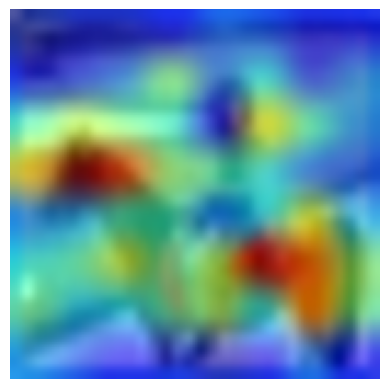

In [16]:
from matplotlib import cm

def DisplaGradcam(img, heatmap, alpha):
    """
    Displays the Grad-CAM visualization of an image.

    Args:
        img (numpy.ndarray): Input image.
        heatmap (numpy.ndarray): The heatmap obtained from Grad-CAM.
        alpha (float): The weight of the heatmap during blending.

    Returns:
        None.
    """
    # Scale the heatmap values to the range [0, 255] and convert them to unsigned 8-bit integers.
    heatmap = np.uint8(255 * heatmap)

    # Get the 'jet' colormap and extract colors corresponding to the heatmap values.
    jet = cm.get_cmap('jet')
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Convert the heatmap to an image and resize it to match the dimensions of the original image.
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Create the superimposed image by blending the original image and the heatmap image with a specified alpha value.
    superimposed_img = jet_heatmap * alpha + img

    # Convert the superimposed image to a PIL image, resize it, and display it using Matplotlib.
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    superimposed_img = superimposed_img.resize((150, 150))
    plt.figure()
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Create the saliecy map.
saliency_map = MakeGradcamMap(x_test[sample], model)

# Combine the saliency map with the original image.
DisplaGradcam(x_test[sample], saliency_map, 0.005)

As we can see, it is not the rider per se that gives this image as a horse, but the horse's head, saddle, and hind legs. You can use these functions to create saliency maps for any Keras-based model, and with a little bit of tweaking, you can apply this method to any CNN-based image classifier.

----

Return to the [castle](https://github.com/Nkluge-correa/TeenyTinyCastle).
